In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # plotting
from xgboost import XGBClassifier
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116058 entries, 0 to 116057
Data columns (total 29 columns):
loan_id                     116058 non-null int64
source                      116058 non-null object
financial_institution       116058 non-null object
interest_rate               116058 non-null float64
unpaid_principal_bal        116058 non-null int64
loan_term                   116058 non-null int64
origination_date            116058 non-null object
first_payment_date          116058 non-null object
loan_to_value               116058 non-null int64
number_of_borrowers         116058 non-null float64
debt_to_income_ratio        116058 non-null float64
borrower_credit_score       116058 non-null float64
loan_purpose                116058 non-null object
insurance_percent           116058 non-null float64
co-borrower_credit_score    116058 non-null float64
insurance_type              116058 non-null float64
m1                          116058 non-null int64
m2                  

In [4]:
train_original = train.copy()
test_original = test.copy()

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35866 entries, 0 to 35865
Data columns (total 28 columns):
loan_id                     35866 non-null int64
source                      35866 non-null object
financial_institution       35866 non-null object
interest_rate               35866 non-null float64
unpaid_principal_bal        35866 non-null int64
loan_term                   35866 non-null int64
origination_date            35866 non-null object
first_payment_date          35866 non-null object
loan_to_value               35866 non-null int64
number_of_borrowers         35866 non-null int64
debt_to_income_ratio        35866 non-null int64
borrower_credit_score       35866 non-null int64
loan_purpose                35866 non-null object
insurance_percent           35866 non-null int64
co-borrower_credit_score    35866 non-null int64
insurance_type              35866 non-null int64
m1                          35866 non-null int64
m2                          35866 non-null int64
m3

<Figure size 432x288 with 0 Axes>

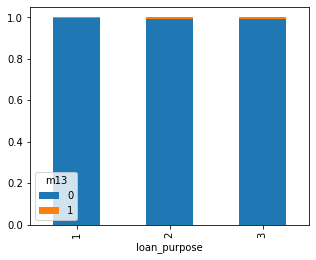

In [37]:
plt.figure(1)
source=pd.crosstab(train['loan_purpose'],train['m13'])
source.div(source.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(5,4))

In [7]:
source_mapping = {'X': 1, 'Y': 2, 'Z': 3,}
train['source'] = train['source'].map(source_mapping)
test['source'] = test['source'].map(source_mapping)

In [8]:
loan_purpose_mapping = {'A23':1,'B12':2,'C86':3}
train['loan_purpose'] = train['loan_purpose'].map(loan_purpose_mapping)
test['loan_purpose'] = test['loan_purpose'].map(loan_purpose_mapping)

In [9]:
train_hot_encoded = pd.get_dummies(train['financial_institution'])
test_hot_encoded = pd.get_dummies(test['financial_institution'])

In [10]:
train_hot_encoded_month = pd.get_dummies(train['first_payment_date'])
test_hot_encoded_month = pd.get_dummies(test['first_payment_date'])

In [11]:
new_train = pd.concat([train,train_hot_encoded],axis=1)
new_test = pd.concat([test,test_hot_encoded],axis=1)

In [12]:
new_train = new_train.drop(['loan_id','financial_institution','origination_date','first_payment_date'],axis=1)
new_test = new_test.drop(['loan_id','financial_institution','origination_date','first_payment_date'],axis=1)

In [13]:
new_test.shape

(35866, 43)

In [14]:
new_train.head()

,source,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,...,Richards-Walters,Richardson Ltd,"Romero, Woods and Johnson","Sanchez, Hays and Wilkerson",Sanchez-Robinson,Suarez Inc,"Swanson, Newton and Miller","Taylor, Hunt and Rodriguez",Thornton-Davis,"Turner, Baldwin and Rhodes"
0,3,4.250,214000,360,95,1.0,22.0,694.0,3,30.0,...,0,0,0,0,0,0,0,0,0,1
1,2,4.875,144000,360,72,1.0,44.0,697.0,2,0.0,...,0,0,0,0,0,0,1,0,0,0
2,3,3.250,366000,180,49,1.0,33.0,780.0,2,0.0,...,0,0,0,0,0,0,0,0,1,0
3,1,4.750,135000,360,46,2.0,44.0,633.0,2,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1,4.750,124000,360,80,1.0,43.0,681.0,3,0.0,...,0,0,0,0,0,0,0,0,0,0


<Figure size 432x288 with 0 Axes>

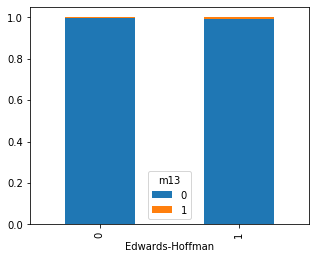

In [98]:
plt.figure(2)
source=pd.crosstab(new_train['Edwards-Hoffman'],new_train['m13'])
source.div(source.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(5,4))

In [15]:
data = new_train.drop('m13',axis=1)

In [65]:
'''from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(data, new_train['m13'])
# display the relative importance of each attribute
print(model.feature_importances_)'''

"from sklearn import datasets\nfrom sklearn import metrics\nfrom sklearn.ensemble import ExtraTreesClassifier\nmodel = ExtraTreesClassifier()\nmodel.fit(data, new_train['m13'])\n# display the relative importance of each attribute\nprint(model.feature_importances_)"

In [97]:
# plot feature importance manually
'''from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot
# fit model no training data
model = XGBClassifier()
model.fit(data, new_train['m13'])
# feature importance
print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()'''

"from numpy import loadtxt\nfrom xgboost import XGBClassifier\nfrom matplotlib import pyplot\n# fit model no training data\nmodel = XGBClassifier()\nmodel.fit(data, new_train['m13'])\n# feature importance\nprint(model.feature_importances_)\n# plot\npyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)\npyplot.show()"

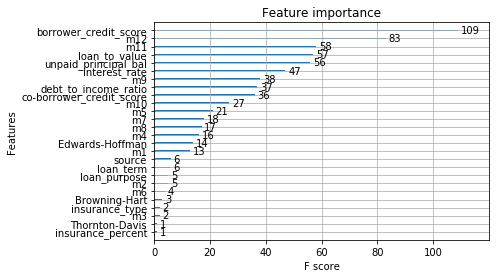

In [18]:
from xgboost import plot_importance
# fit model no training data
model = XGBClassifier()
model.fit(data, new_train['m13'])
# plot feature importance
plot_importance(model)
pyplot.show()

In [84]:
train_data = data[['borrower_credit_score','m12','m11','loan_to_value','interest_rate','m9','debt_to_income_ratio','co-borrower_credit_score','m10']]
test_data = new_test[['borrower_credit_score','m12','m11','loan_to_value','interest_rate','m9','debt_to_income_ratio','co-borrower_credit_score','m10']]

In [85]:
x_train, x_cv, y_train, y_cv = train_test_split(train_data,new_train['m13'], test_size =0.3)

In [86]:
y_train.value_counts()

0    80811
1      429
Name: m13, dtype: int64

In [87]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=27, ratio=0.5)
X_train_res, y_train_res = sm.fit_sample(x_train, y_train.ravel())

In [76]:
model = LogisticRegression()
model.fit(x_train, y_train)
pred_cv = model.predict(x_cv)
print(round(accuracy_score(y_cv,pred_cv)*100 ,2))

99.45


c:\users\gaurav\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_cv, pred_cv).ravel()

array([34622,    21,   175,     0], dtype=int64)

In [25]:
f1_score(y_cv, pred_cv, average='binary')

0.0

In [59]:
from sklearn import tree
decisiontree = tree.DecisionTreeClassifier()
decisiontree.fit(X_train_res, y_train_res)
y_pred = decisiontree.predict(x_cv)

In [60]:
confusion_matrix(y_cv, y_pred).ravel()

array([34478,   165,   112,    63], dtype=int64)

In [61]:
f1_score(y_cv, y_pred, average='binary')

0.3126550868486353

In [94]:
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier()
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_cv)

c:\users\gaurav\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [95]:
confusion_matrix(y_cv, y_pred).ravel()

array([34576,    35,   131,    76], dtype=int64)

In [93]:
f1_score(y_cv, y_pred, average='binary')

0.4873417721518988

In [42]:
pred_test = randomforest.predict(test_data)

In [43]:
submission = pd.read_csv('sample_submission.csv')

In [44]:
submission['m13']=pred_test
submission['loan_id']=test_original['loan_id']
pd.DataFrame(submission, columns=['loan_id','m13']).to_csv('final_submission.csv')